In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
samples = 2000
features = 2
data, label = make_classification(n_features=features,
                                  n_clusters_per_class=1, 
                                  n_samples=samples,
                                  n_informative=features,
                                  n_redundant=0,
                                  n_repeated=0,
                                  n_classes=2)
label = label.reshape((len(label), 1))

In [2]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 2), (400, 2), (1600, 1), (400, 1))

In [4]:
train = pd.DataFrame(X_train, columns=[f'f{i}' for i in range(features)])
train['label'] = y_train

test = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(features)])
test['label'] = y_test

In [5]:
def plot_graph(df):
    t = df.query('label == 0')
    x, y = t['f0'].values, t['f1'].values
    plt.scatter(x, y)
    t = df.query('label == 1')
    x, y = t['f0'].values, t['f1'].values
    plt.scatter(x, y)
    plt.legend(['0', '1'])
    plt.show()

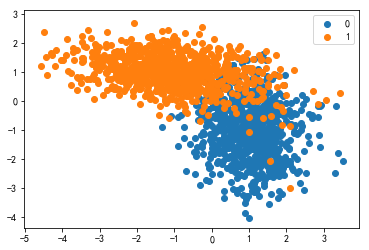

In [6]:
plot_graph(train)

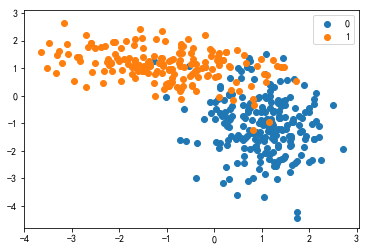

In [7]:
plot_graph(test)

In [8]:
all_data = pd.DataFrame(data, columns=[f'f{i}' for i in range(features)])
all_data['label'] = label

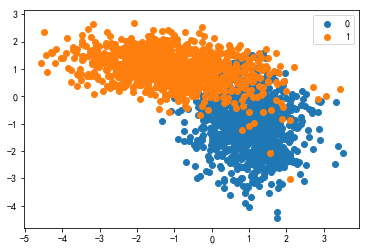

In [9]:
plot_graph(all_data)

In [10]:
# 计算训练集合上的均值 最大值 最小值 用来归一化
mean = np.mean(X_train, axis=0)
maxium = np.max(X_train, axis=0)
minium = np.min(X_train, axis=0)

# 归一化
def normalizition(X, maxium=maxium, minium=minium, mean=mean):
    return (X - mean) / (maxium - minium)

X_train = normalizition(X_train)
X_test = normalizition(X_test)

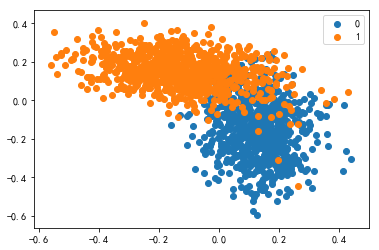

In [11]:
# 下面绘制归一化后的数据集情况
t = pd.DataFrame(X_train, columns=[f'f{i}' for i in range(features)])
t['label'] = y_train
plot_graph(t)

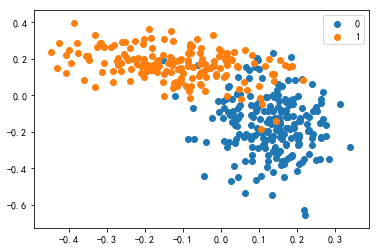

In [12]:
t = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(features)])
t['label'] = y_test
plot_graph(t)

In [13]:
# activation func:sigmoid
def sigmoid(x):
    return 1 / (1+np.exp(-x))

# activation func:relu
def relu(x):
    return np.maximum(x, 0)
# relu的导数
def relu_prime(z):
    z[z>0]=1
    return z

# loss function
def binary_crossentropy(label, pred_y):
    return np.sum(-label * np.log(pred_y) - (1 - label) * np.log(1 - pred_y))

# metric
def accuracy(label, pred_y):
    return np.mean(label == (pred_y > 0.5).astype(np.int))

# predict
def predict(X, model):
    l1_out = relu(np.dot(X, model['w0']))
    l2_out = relu(np.dot(l1_out, model['w1']))
    pred_y = sigmoid(np.dot(l2_out, model['w2']))
    return pred_y

In [14]:
# 绘制决策边界
def plot_decision_boundary(pred_func, X, y):
 
    # 设定最大最小值，附加一点点边缘填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
 
    # 用预测函数预测一下
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
 
    # 然后画出图
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape((len(y), )), cmap=plt.cm.Spectral)


In [15]:
# best model
best_model = {"w0":None, 
              "w1":None, 
              "w2":None}
# 早停轮次
stop_epoch = 10
early_stopping = {"epoch":stop_epoch,
                  "current_epoch":0}
# 最佳得分
best_score = -np.inf
# 最佳epoch
best_epoch = 1
# 迭代次数
epoch = 3000
# 存储loss
cost = []
# metric
train_metric = []
val_metric = []
# 学习率 : 可以更改一下放大或者缩小10倍，看看下面的loss图的变化
alpha = 0.001
# 初始化权重
# np.random.seed(seed=620)
w0 = np.random.normal(size=(X_train.shape[1], 10))
w1 = np.random.normal(size=(10, 8))
w2 = np.random.normal(size=(8, 1))
for i in range(epoch):
    # 正向传播
    l1_out = relu(np.dot(X_train, w0))
    l2_out = relu(np.dot(l1_out, w1))
    pred_y = sigmoid(np.dot(l2_out, w2))
    # 反向传播
#     pred_err = (y_train - pred_y) * (pred_y * (1 - pred_y))
#     l2_to_l1_err = pred_err.dot(w2.T) * (l2_out * (1 - l2_out))
#     l1_to_input_err = l2_to_l1_err.dot(w1.T) * (l1_out * (1 - l1_out))
    pred_err = (y_train - pred_y) * (pred_y * (1 - pred_y))
    l2_to_l1_err = pred_err.dot(w2.T) * relu_prime(l2_out)
    l1_to_input_err = l2_to_l1_err.dot(w1.T) * relu_prime(l1_out)
    # 根据误差更新权重
    w2 += alpha * l2_out.T.dot(pred_err)
    w1 += alpha * l1_out.T.dot(l2_to_l1_err)
    w0 += alpha * X_train.T.dot(l1_to_input_err)
    model = {"w0":w0, "w1":w1, "w2":w2}
    # 训练集的loss
    cost.append(binary_crossentropy(y_train, pred_y))
    # 训练集metric
    train_metric.append(accuracy(label=y_train, pred_y=pred_y))
    # 测试集 metric
    test_y = predict(X_test, model)
#     print(test_y.shape, y_test.shape)
    score = accuracy(label=y_test, pred_y=test_y)
    val_metric.append(score)
    if score > best_score:
        best_score = score
        best_epoch = i
        best_model['w0'] = w0
        best_model['w1'] = w1
        best_model['w2'] = w2
        early_stopping = {"epoch":stop_epoch,
                          "current_epoch":0}
    early_stopping['current_epoch'] += 1
    if early_stopping["epoch"] == early_stopping["current_epoch"]:
        break
#         pass
#     if i % 30 == 0:
    print('epoch-->>', i, 
          'cost-->> ', cost[-1],
          'train metric -->>', train_metric[-1], 
          'test metric -->>', val_metric[-1])    

epoch-->> 0 cost-->>  1453.00672825 train metric -->> 0.156875 test metric -->> 0.45
epoch-->> 1 cost-->>  952.510613156 train metric -->> 0.51875 test metric -->> 0.4625
epoch-->> 2 cost-->>  851.518212192 train metric -->> 0.5325 test metric -->> 0.49
epoch-->> 3 cost-->>  808.108379624 train metric -->> 0.5575 test metric -->> 0.7775
epoch-->> 4 cost-->>  776.665420997 train metric -->> 0.80375 test metric -->> 0.8725
epoch-->> 5 cost-->>  750.12778914 train metric -->> 0.891875 test metric -->> 0.9
epoch-->> 6 cost-->>  725.631513945 train metric -->> 0.905 test metric -->> 0.905
epoch-->> 7 cost-->>  701.527166723 train metric -->> 0.91125 test metric -->> 0.91
epoch-->> 8 cost-->>  676.792422386 train metric -->> 0.915 test metric -->> 0.91
epoch-->> 9 cost-->>  650.912910249 train metric -->> 0.91625 test metric -->> 0.9175
epoch-->> 10 cost-->>  623.82028625 train metric -->> 0.9175 test metric -->> 0.9225
epoch-->> 11 cost-->>  595.954651233 train metric -->> 0.921875 test met

In [16]:
f"best_epoch:{best_epoch}, best_score:{best_score}"

'best_epoch:14, best_score:0.935'

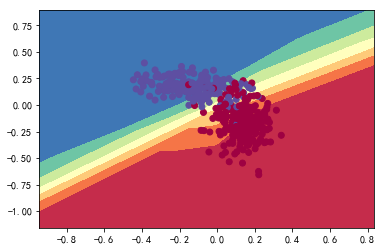

In [17]:
# 绘制训练集的决策边界
plot_decision_boundary(pred_func=lambda x : predict(x, best_model), X=X_test, y=y_test)
plt.show()

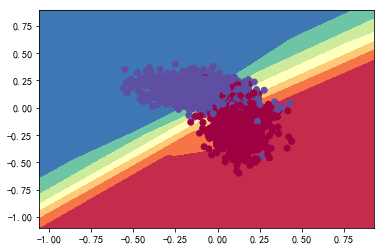

In [18]:
# 绘制测试集合的决策边界
plot_decision_boundary(pred_func=lambda x : predict(x, best_model), X=X_train, y=y_train)
plt.show()

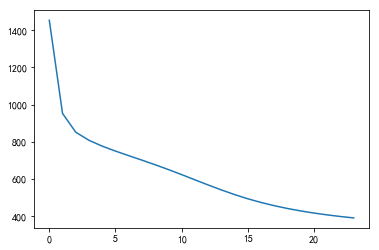

In [19]:
# loss曲线
plt.plot(list(range(len(cost))), cost)
plt.show()

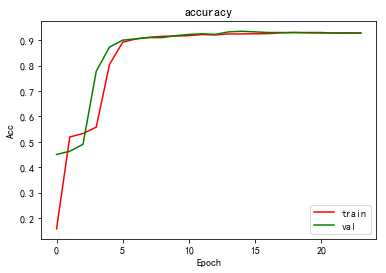

In [20]:
# metric 曲线
plt.plot(list(range(len(train_metric))), train_metric, color='r')
plt.plot(list(range(len(val_metric))), val_metric, color='g')
plt.legend(['train', 'val'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()

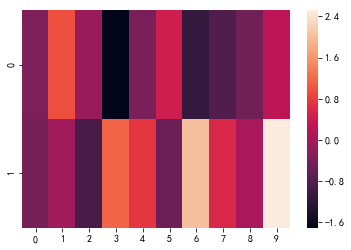

In [21]:
# w0权重
sns.heatmap(best_model['w0'])
plt.show()

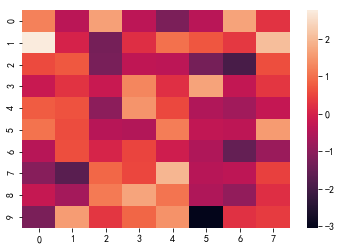

In [22]:
# w1 权重
sns.heatmap(best_model['w1'])
plt.show()

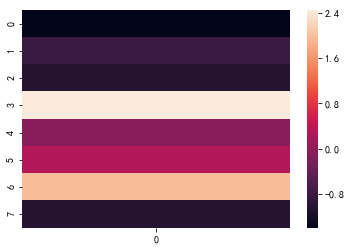

In [23]:
# w2权重
sns.heatmap(best_model['w2'])
plt.show()